### Экспериментальная мультимодальная система, основанная на текстовом якоре

[Ссылка на архив с данными с ноутбука, содержимое распаковать в папку data](https://drive.google.com/file/d/1pO8gCmjRvnu8Q9-aIK7w7aV7PrcnY0Hj/view?usp=sharing)

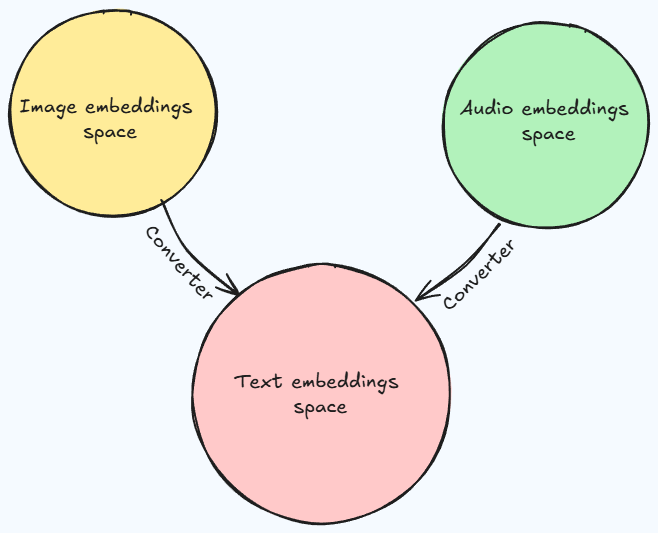

In [1]:
import pandas as pd
from params import *
from data import *
import pickle
from models import *
import os
from torch import nn
from torch.optim import Adam
from train import Trainer
from eval import *
from metrics import *
from sklearn.manifold import TSNE

In [2]:
# читаем датафреймы с разметкой
it = pd.read_csv('data/mnist/image.csv')
at = pd.read_csv('data/mnist/audio.csv')

In [3]:
it.head()

,path,y
0,data/mnist/images/0.jpg,5
1,data/mnist/images/1.jpg,0
2,data/mnist/images/2.jpg,4
3,data/mnist/images/3.jpg,1
4,data/mnist/images/4.jpg,9


#### Переразмечаем датафреймы в стандартный формат

Парсер требует данные в виде:

Соответствие переменных и колонок:  
- `OBJECT1_COLUMN_NAME` → `object1`  
- `OBJECT2_COLUMN_NAME` → `object2`  
- `TYPE1_COLUMN_NAME` → `type1`  
- `TYPE2_COLUMN_NAME` → `type2`

| object1                     | object2 | type1 | type2 |
|-----------------------------|---------|-------|-------|
| data/mnist/images/0.jpg     | 5       | img   | text  |
| data/mnist/images/1.jpg     | 0       | img   | text  |
| data/mnist/images/2.jpg     | 4       | img   | text  |
| data/mnist/images/3.jpg     | 1       | img   | text  |
| data/mnist/images/4.jpg     | 9       | img   | text  |

**Важно!** object2 и type2 должны быть текстом, те ядром(сейчас весь код написан под текст, пока что), изображения и аудио должны быть в виде пути к изображению/wav файлу

In [4]:
it['y'] = it['y'].astype(str)
it[TYPE1_COLUMN_NAME] = TYPE_IMAGE
it[TYPE2_COLUMN_NAME] = TYPE_TEXT
it.rename(columns={
    "path": OBJECT1_COLUMN_NAME,
    "y": OBJECT2_COLUMN_NAME
}, inplace=True)

at['y'] = at['y'].astype(str)
at[TYPE1_COLUMN_NAME] = TYPE_AUDIO
at[TYPE2_COLUMN_NAME] = TYPE_TEXT
at.rename(columns={
    "pths": OBJECT1_COLUMN_NAME,
    "y": OBJECT2_COLUMN_NAME
}, inplace=True)

In [5]:
ndf = pd.concat([it, at], ignore_index=True)

#### Загружаем предпосчитанные(оригинальные) эмбеддинги

In [6]:
base_path = "data/mnist/"

with open(os.path.join(base_path, 'id_audio.pkl'), 'rb') as f:
    id_audio = pickle.load(f)

with open(os.path.join(base_path, 'id_image.pkl'), 'rb') as f:
    id_image = pickle.load(f)

with open(os.path.join(base_path, 'id_text.pkl'), 'rb') as f:
    id_text = pickle.load(f)

In [7]:
initial = InitialDataset(ndf) # Связывает id и оригинальных контент

print('Initial Dataset created')

Initial Dataset created


In [8]:
orig_embs = id_image | id_text | id_audio

#### Создаем датасеты и обучаем проекторы

In [9]:
ds = ID_Dataset(initial.return_id_df(mode=TYPE_IMAGE), orig_embs) # Датасет pytorch для обучения
dataloader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
model_images = ConverterModel(512, 768).to(DEVICE)
optim = Adam(model_images.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [10]:
trainer = Trainer(
    model=model_images,
    dataset=ds,
    dl=dataloader,
    epochs=3,
    batch_size=TRAIN_BATCH_SIZE,
    optimizer=optim,
    criterion=criterion
)

model_images = trainer.train()

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1. Loss = 4.212780882539846e-05


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2. Loss = 4.585784397548309e-06


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3. Loss = 2.6160413808540284e-06


In [11]:
i_embs = ds.get_embs_from_ids(initial.return_ids_of_objects(TYPE_IMAGE))
i_res = encode_tensors(model_images, i_embs)
i_dict = {i: v for i, v in zip(initial.return_ids_of_objects(TYPE_IMAGE), i_res)}

  0%|          | 0/118 [00:00<?, ?it/s]

In [12]:
ds = ID_Dataset(initial.return_id_df(mode=TYPE_AUDIO), orig_embs)
dataloader = DataLoader(ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
model_audio = ConverterModel(512, 768).to(DEVICE)
optim = Adam(model_audio.parameters(), lr=5e-4)
criterion = nn.MSELoss()

print('Starting trainining...')

trainer = Trainer(
    model=model_audio,
    dataset=ds,
    dl=dataloader,
    epochs=5,
    batch_size=TRAIN_BATCH_SIZE,
    optimizer=optim,
    criterion=criterion
)

model_audio = trainer.train()


Starting trainining...


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1. Loss = 3.708802097435182e-05


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2. Loss = 9.784779109622832e-06


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3. Loss = 4.246034766453022e-06


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4. Loss = 3.086339255276016e-06


  0%|          | 0/59 [00:00<?, ?it/s]

--- Metric ---
Mean = 0.9915297031402588
STD = 0.01782289333641529
median = 0.9976506233215332



In [13]:
a_embs = ds.get_embs_from_ids(initial.return_ids_of_objects(TYPE_AUDIO))
a_res = encode_tensors(model_audio, a_embs)
a_dict = {i: v for i, v in zip(initial.return_ids_of_objects(TYPE_AUDIO), a_res)}

  0%|          | 0/59 [00:00<?, ?it/s]

In [14]:
ready = Ready_Embeddings_Dataset( # Связывание готовых эмбов и id
    texts=id_text,
    images=i_dict,
    audios=a_dict
)

In [15]:
tsne = TSNE()
d = tsne.fit_transform(a_res)

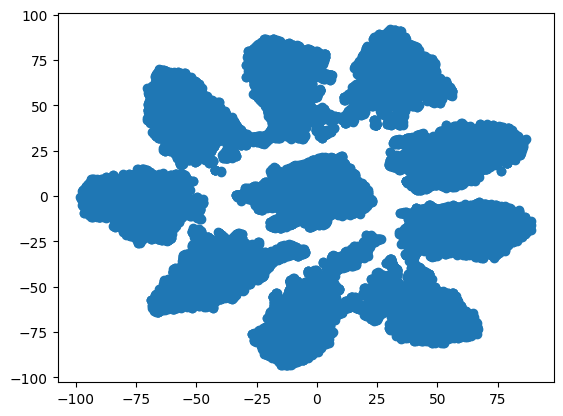

In [16]:
plt.scatter(d[:, 0], d[:, 1])
plt.show()

#### Валидация

##### Text --> Image

---- SAMPLE 1 ----
5
--- SEARCH BY TEXT -> IMAGES ---


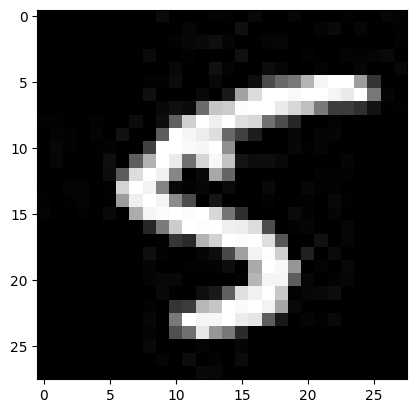

In [17]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_TEXT)

##### Image --> Text

---- SAMPLE 1 ----


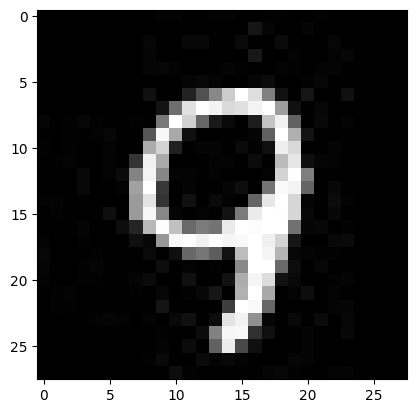

--- SEARCH BY IMAGE -> TEXTS ---
9


In [18]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_IMAGE)

##### Audio --> Image

>Примечание: у мнист датасета записи очень тихие, тч не пугайтесь, если там кажется тишина

---- SAMPLE 1 ----


--- SEARCH BY AUDIO -> IMAGE ---


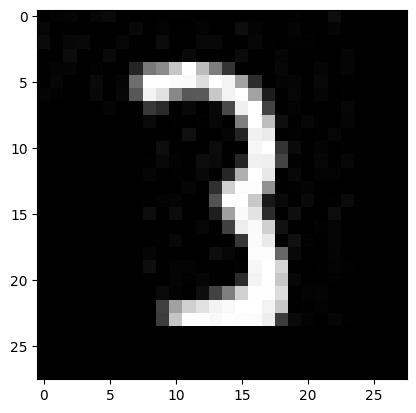

In [19]:
visual_validation(initial, ready, n_samples=1, n_neib=1, sby=TYPE_AUDIO)

#### VAE Experiment

Train:
img_emb --> img

Val:
object --> img

In [24]:
ids = initial.return_ids_of_objects(TYPE_IMAGE)

In [26]:
x = []
for i in ids:
    x.append(ready.get_image_emb_by_id(i))
x = torch.stack(x)

In [28]:
from torchvision.io import read_image

In [32]:
y = []
for i in tqdm(ids):
    y.append(read_image(initial.get_object_by_global_id(i).content))
y = torch.stack(y)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
import torch
import torch.nn as nn

class CompactDecoder(nn.Module):
    def __init__(self, embedding_dim=768):
        super(CompactDecoder, self).__init__()
        
        self.main = nn.Sequential(
            # Преобразуем эмбеддинг в тензор 7x7x128
            nn.Linear(embedding_dim, 7*7*128),
            nn.Unflatten(1, (128, 7, 7)),  # [batch, 128, 7, 7]
            
            # Upsampling до 28x28
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            # Финальный слой
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.main(x)

In [38]:
y = y / 255

In [40]:
vae = CompactDecoder()

In [41]:
ds = TensorDataset(x, y)
dl = DataLoader(ds, batch_size=32, shuffle=True)
optim = Adam(vae.parameters())

In [42]:
loss = nn.MSELoss()

In [45]:
epochs = 5

In [47]:
for e in range(epochs):
    ttl = 0
    for xb, yb in tqdm(dl):
        optim.zero_grad()
        pred = vae(xb)
        ls = loss(pred, yb)
        ttl += ls.item()
        ls.backward()
        optim.step()
    print(f'Epoch {e}. Loss = {ttl / dl.batch_size}')

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 0. Loss = 3.0363790184492245


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1. Loss = 3.01679829088971


  0%|          | 0/1875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
tp = x[1].unsqueeze(0)

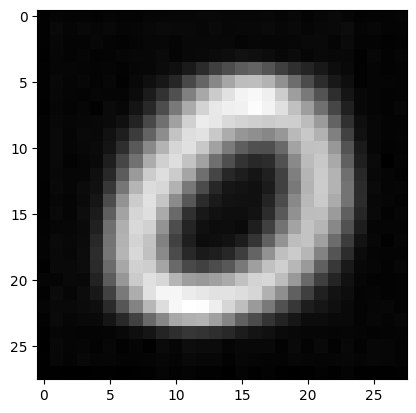

In [60]:
plt.imshow(vae(tp).squeeze(0).permute(1,2,0).detach().numpy(), cmap='gray')
plt.show()

C:\Users\ddimo\AppData\Local\Temp\ipykernel_14312\1400010560.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tpred = torch.tensor(ready.get_audio_emb_by_id(i)).unsqueeze(0)


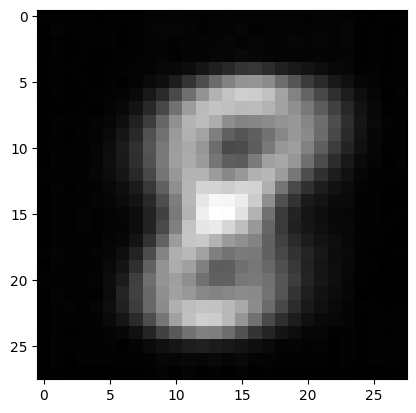

In [80]:
et = TYPE_AUDIO
pids = initial.return_ids_of_objects(et)
i = pids[randint(0, len(pids))]
initial.get_object_by_global_id(i).show()
tpred = torch.tensor(ready.get_audio_emb_by_id(i)).unsqueeze(0)
plt.imshow(vae(tpred).squeeze(0).permute(1,2,0).detach().numpy(), cmap='gray')
plt.show()